Initial full dataset size: (431371, 79)
Size after removing missing values/duplicates: (426322, 79)


c:\Users\taejo\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 지정된 파일을 찾을 수 없습니다
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\taejo\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\taejo\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\taejo\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\taejo\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
 

Number of data in each cluster: 
cluster
0     130194
10     95546
9      56582
6      21740
2      19932
1      18289
12     14605
4      12165
14     10894
3       9605
17      8222
11      7668
8       6309
7       5009
15      4382
5       2476
16      1411
13      1293
Name: count, dtype: int64


c:\Users\taejo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\taejo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\taejo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



--- Confusion Matrix ---
[[81877     0     0     0    58     0     1     0     0    67     0     0
  12636   311     0     0     0     0]
 [  242     0     0     0   295     0  2188     0     0   794     0     0
      1   149     0     0     0     0]
 [    4     0     0     0     0     0  1422     0     0     8     0     0
      2     4     0     0     0     0]
 [    4     0     0     0   614     0   566     0     0  4264     0     0
      0   764     0     0     0     0]
 [20259     0     0     0 99500     0     2     0     0   551     0     0
     54  1002     0     0     0     0]
 [  207     0     0     0    93     0    17     0     0   232     0     0
      3    46     0     0     0     0]
 [   51     0     0     0    17     0  2602     0     0    38     0     0
      1     8     0     0     0     0]
 [    8     0     0     0  9519     0    14     0     0   398     0     0
      1   480     0     0     0     0]
 [    7     0     0     0     0     0  1848     0     0    27     0   

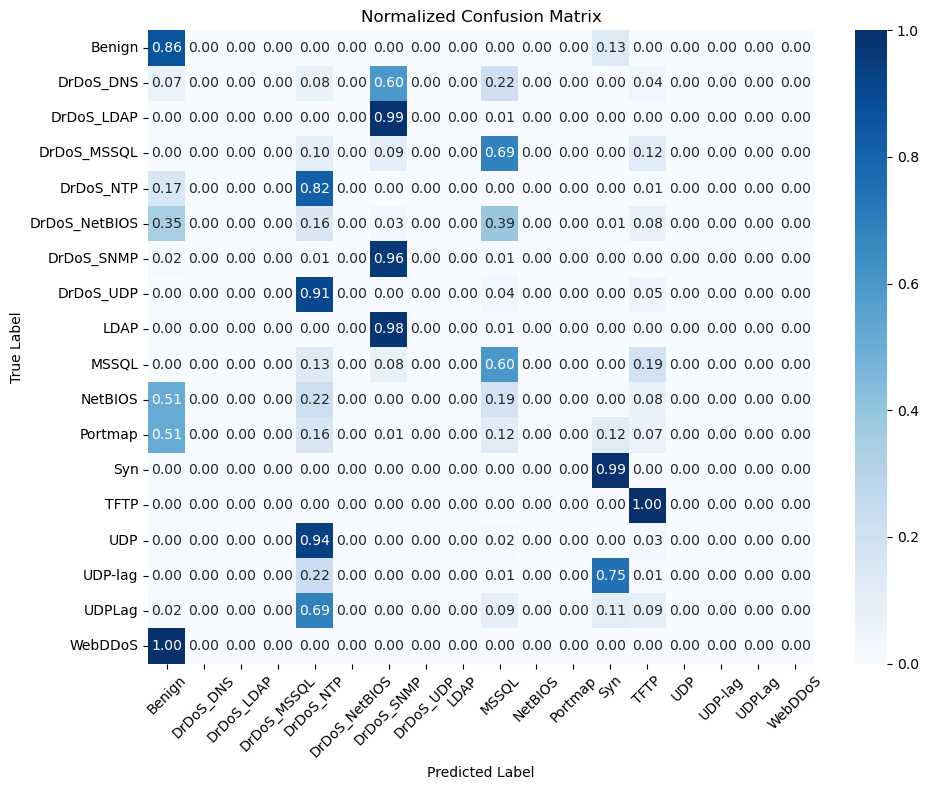

In [1]:
import glob
import pandas as pd 
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

##########################################
# 1) Load Data and Preprocessing (Existing Code)
##########################################
train_files = glob.glob("../data/*training.parquet")
test_files  = glob.glob("../data/*testing.parquet")

df_list = []
for f in train_files:
    temp = pd.read_parquet(f)
    temp['set_type'] = 'train'
    df_list.append(temp)
for f in test_files:
    temp = pd.read_parquet(f)
    temp['set_type'] = 'test'
    df_list.append(temp)

df_all = pd.concat(df_list, ignore_index=True)
print("Initial full dataset size:", df_all.shape)

df_all.dropna(inplace=True)
df_all.drop_duplicates(inplace=True)
print("Size after removing missing values/duplicates:", df_all.shape)

##########################################
# 2) Data Scaling (Range 0~1)
##########################################
# Exclude Label and set_type from clustering
feature_columns = df_all.columns.difference(['Label', 'set_type'])
scaler = MinMaxScaler()
df_all[feature_columns] = scaler.fit_transform(df_all[feature_columns]).astype(np.float32)

##########################################
# 3) KMeans Clustering
##########################################
# Cluster Number = Benign + DDoS Category: 18 
kmeans = KMeans(n_clusters=18, random_state=0)
df_all['cluster'] = kmeans.fit_predict(df_all[feature_columns])
print("Number of data in each cluster: ")
print(df_all['cluster'].value_counts())

##########################################
# 4) Cluster Mapping: Generate Predicted Labels Using the Mode of True Labels in Each Cluster
##########################################
# Compute the mode of the true labels for data in each cluster.
cluster_mode = df_all.groupby('cluster')['Label'].agg(lambda x: x.mode().iloc[0])
df_all['predicted_label'] = df_all['cluster'].map(cluster_mode)

##########################################
# 5) Evaluation: Confusion Matrix, Accuracy, Classification Report
##########################################
y_true = df_all['Label'].astype(str).str.strip()
y_pred = df_all['predicted_label'].astype(str).str.strip()

cm = confusion_matrix(y_true, y_pred, labels=sorted(np.unique(y_true)))
accuracy = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred)

print("\n--- Confusion Matrix ---")
print(cm)
print("\nAccuracy: {:.2f}%".format(accuracy * 100))
print("\nClassification Report:")
print(report)

##########################################
# 6) Visualization of Normalized Confusion Matrix
##########################################
# Normalize each row: compute the proportion by dividing by the row sum
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Use sorted true labels as tick labels
labels = sorted(np.unique(y_true))

plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


